In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as st

In [5]:
url = '../data/clean/combined_data_test.txt'
df = pd.read_csv(url)

In [11]:
# Ensure date_time is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])
# Sort by client_id, visit_id, and date_time to ensure chronological order
df = df.sort_values(by=['client_id',"visitor_id", "visit_id",'date_time'])
# Define the process steps in the correct order
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
# Create a new column that shows the next step
df['next_step'] = df.groupby(['client_id',"visitor_id", "visit_id"])['process_step'].shift(-1)

In [14]:
# Identify step-back errors
df['is_step_back'] = df.apply(
    lambda row: process_order.index(row['next_step']) < process_order.index(row['process_step']) 
    if pd.notnull(row['next_step']) else False, axis=1
)

In [17]:
# Calculate total steps and total errors
total_steps = len(df)  # Total number of rows (steps)
total_step_back_errors = df['is_step_back'].sum()  # Sum of step-back errors
total_step_back_errors

16248

In [24]:
# Calculate the overall error rate
total_error_rate = total_step_back_errors / total_steps * 100

print(f"Total number of steps: {total_steps}")
print(f"Total number of step-back errors: {total_step_back_errors}")
print(f"Total error rate: {total_error_rate:.6f}%")

Total number of steps: 176641
Total number of step-back errors: 16248
Total error rate: 9.198317%


In [27]:
# 1) Filter and get the last 'start' and 'confirm' time for each client
start_df = (df[df['process_step'] == 'start']
            .sort_values(by=['visit_id', 'date_time'])
            .groupby(['visit_id'])
            .tail(1)[['visit_id', 'date_time']]
            .rename(columns={'date_time': 'start_time'}))

# Filter and get the last 'confirm' time for each client, visitor, and visit
confirm_df = (df[df['process_step'] == 'confirm']
              .sort_values(by=['visit_id', 'date_time'])
              .groupby(['visit_id'])
              .tail(1)[['visit_id', 'date_time']]
              .rename(columns={'date_time': 'confirm_time'}))

In [33]:
# 2) Merge the two DataFrames on client_id
merged_df = pd.merge(start_df, confirm_df, on='visit_id', how='left')  # use 'left' to keep all clients with 'start' step
merged_df

,visit_id,start_time,confirm_time
0,100019538_17884295066_43909,2017-04-09 16:21:59,2017-04-09 16:24:58
1,100022086_87870757897_149620,2017-05-23 20:44:01,2017-05-23 20:47:01
2,100173292_91322748906_143563,2017-04-25 10:28:55,2017-04-25 10:30:30
3,100217156_67053490690_383412,2017-04-12 11:51:12,2017-04-12 12:08:09
4,100221419_95702886123_228743,2017-04-09 07:22:29,NaT
...,...,...,...
33139,999960019_60838685252_926860,2017-04-19 19:27:51,NaT
33140,999971096_28827267783_236076,2017-04-13 10:31:49,2017-04-13 10:34:08
33141,999976049_95772503197_182554,2017-04-04 12:50:10,2017-04-04 13:02:18
33142,999984454_18731538378_781808,2017-03-29 11:18:33,2017-03-29 11:21:07


In [36]:
# 3) Calculate the process time (confirm_time - start_time) in minutes
merged_df['process_duration'] = (merged_df['confirm_time'] - merged_df['start_time']).dt.total_seconds() / 60  # Convert to minutes
merged_df

,visit_id,start_time,confirm_time,process_duration
0,100019538_17884295066_43909,2017-04-09 16:21:59,2017-04-09 16:24:58,2.983333
1,100022086_87870757897_149620,2017-05-23 20:44:01,2017-05-23 20:47:01,3.000000
2,100173292_91322748906_143563,2017-04-25 10:28:55,2017-04-25 10:30:30,1.583333
3,100217156_67053490690_383412,2017-04-12 11:51:12,2017-04-12 12:08:09,16.950000
4,100221419_95702886123_228743,2017-04-09 07:22:29,NaT,NaN
...,...,...,...,...
33139,999960019_60838685252_926860,2017-04-19 19:27:51,NaT,NaN
33140,999971096_28827267783_236076,2017-04-13 10:31:49,2017-04-13 10:34:08,2.316667
33141,999976049_95772503197_182554,2017-04-04 12:50:10,2017-04-04 13:02:18,12.133333
33142,999984454_18731538378_781808,2017-03-29 11:18:33,2017-03-29 11:21:07,2.566667


In [39]:
merged_df[['visit_id', 'start_time', 'confirm_time', 'process_duration']]

,visit_id,start_time,confirm_time,process_duration
0,100019538_17884295066_43909,2017-04-09 16:21:59,2017-04-09 16:24:58,2.983333
1,100022086_87870757897_149620,2017-05-23 20:44:01,2017-05-23 20:47:01,3.000000
2,100173292_91322748906_143563,2017-04-25 10:28:55,2017-04-25 10:30:30,1.583333
3,100217156_67053490690_383412,2017-04-12 11:51:12,2017-04-12 12:08:09,16.950000
4,100221419_95702886123_228743,2017-04-09 07:22:29,NaT,NaN
...,...,...,...,...
33139,999960019_60838685252_926860,2017-04-19 19:27:51,NaT,NaN
33140,999971096_28827267783_236076,2017-04-13 10:31:49,2017-04-13 10:34:08,2.316667
33141,999976049_95772503197_182554,2017-04-04 12:50:10,2017-04-04 13:02:18,12.133333
33142,999984454_18731538378_781808,2017-03-29 11:18:33,2017-03-29 11:21:07,2.566667


In [42]:
# Drop missing values to have only the clients that finished the process
merged_df = merged_df.dropna(subset=['process_duration'])
merged_df

,visit_id,start_time,confirm_time,process_duration
0,100019538_17884295066_43909,2017-04-09 16:21:59,2017-04-09 16:24:58,2.983333
1,100022086_87870757897_149620,2017-05-23 20:44:01,2017-05-23 20:47:01,3.000000
2,100173292_91322748906_143563,2017-04-25 10:28:55,2017-04-25 10:30:30,1.583333
3,100217156_67053490690_383412,2017-04-12 11:51:12,2017-04-12 12:08:09,16.950000
6,100258507_71262593004_214494,2017-03-29 12:43:41,2017-03-29 12:49:32,5.850000
...,...,...,...,...
33137,999954858_74676709104_879685,2017-04-05 11:13:34,2017-04-05 11:15:41,2.116667
33138,999958344_67534252886_39917,2017-04-15 00:34:32,2017-04-15 00:36:59,2.450000
33140,999971096_28827267783_236076,2017-04-13 10:31:49,2017-04-13 10:34:08,2.316667
33141,999976049_95772503197_182554,2017-04-04 12:50:10,2017-04-04 13:02:18,12.133333


In [45]:
# Average of time to complete the process (15,312 rows)
merged_df.process_duration.mean()

5.254115927456895

In [50]:
# Step 1: Calculate the average process_duration
avg_process_duration = merged_df['process_duration'].mean()

# Step 2: Filter the DataFrame to include only rows where process_duration is greater than the average
filtered_df = merged_df[merged_df['process_duration'] > avg_process_duration]

# Step 3: Get the unique client_ids from the filtered DataFrame
clients_above_avg_duration = filtered_df['visit_id'].unique()

# If you just want to see the client_ids:
print(clients_above_avg_duration)

['100217156_67053490690_383412' '100258507_71262593004_214494'
 '100412222_23957663994_946900' ... '999817126_86162597254_111325'
 '999891710_95999857132_598498' '999976049_95772503197_182554']


In [53]:
max_duration = filtered_df['process_duration'].max()
max_duration

277.55

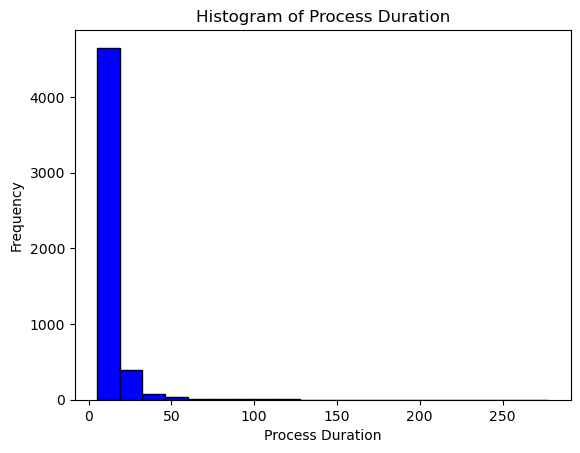

In [57]:
# Create a histogram of the 'process_duration' column
plt.hist(filtered_df['process_duration'], bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Process Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Process Duration')

# Display the plot
plt.show()

In [63]:
# Calculate Q1, Q3 and IQR
Q1 = filtered_df['process_duration'].quantile(0.25)
Q3 = filtered_df['process_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = filtered_df[(filtered_df['process_duration'] >= lower_bound) & (filtered_df['process_duration'] <= upper_bound)]

# Check the shape of the new dataframe (rows after removing outliers)
print(f"Original data: {df.shape[0]} rows, Filtered data: {df_filtered.shape[0]} rows")

Original data: 176641 rows, Filtered data: 4769 rows


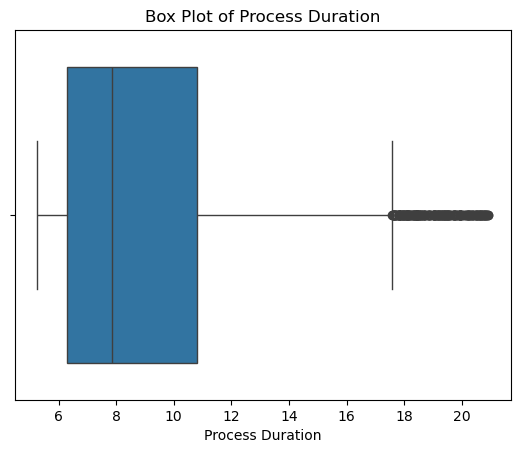

In [67]:
# Box plot to visualize the distribution of 'process_duration'
sns.boxplot(x=df_filtered['process_duration'])

# Add title and labels
plt.title('Box Plot of Process Duration')
plt.xlabel('Process Duration')

# Display the plot
plt.show()

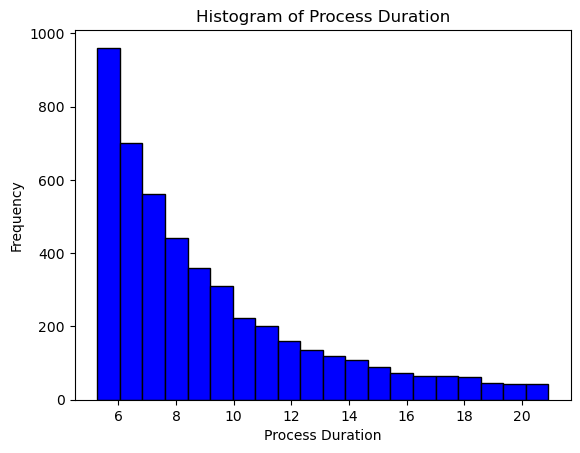

In [71]:
# Create a histogram of the 'process_duration' column
plt.hist(df_filtered['process_duration'], bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Process Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Process Duration')

# Display the plot
plt.show()

In [74]:
# Average of time to complete the process 4,977 rows
df_filtered.process_duration.mean()

9.090305444887118

In [78]:
# Measures of centrality of the column balance: 
mean_process_duration = df_filtered["process_duration"].mean()
median_process_duration = df_filtered['process_duration'].median()
mode_process_duration = df_filtered['process_duration'].mode()[0]
print(mean_process_duration)
print(median_process_duration)
print(mode_process_duration)

9.090305444887118
7.866666666666666
5.266666666666667


In [81]:
# Measures of dispersion of the column balance: 
variance_process_duration = df_filtered['process_duration'].var()
std_dev_process_duration = df_filtered['process_duration'].std()
min_process_duration = df_filtered['process_duration'].min()
max_process_duration = df_filtered['process_duration'].max()
range_process_duration = max_process_duration - min_process_duration
quantiles_process_duration = df_filtered['process_duration'].quantile([0.25, 0.5, 0.75])
print(variance_process_duration)
print(std_dev_process_duration)
print(min_process_duration)
print(max_process_duration)
print(range_process_duration)
print(quantiles_process_duration)

13.349258741042508
3.653663742196661
5.266666666666667
20.916666666666668
15.650000000000002
0.25     6.283333
0.50     7.866667
0.75    10.800000
Name: process_duration, dtype: float64


In [84]:
skewness_process_duration = df_filtered['process_duration'].skew()
kurtosis_process_duration = df_filtered['process_duration'].kurtosis()
print(skewness_process_duration)
print(kurtosis_process_duration)

1.2628586890430205
0.8895102215342816


In [87]:
# Calculate the time difference between consecutive steps for each user
df['time_diff'] = df.groupby(['client_id', 'visitor_id', 'visit_id'])['date_time'].diff()
df['time_diff']

176639               NaT
176638   0 days 00:00:07
176637   0 days 00:00:32
176636   0 days 00:01:39
176640   0 days 00:00:20
               ...      
10       0 days 00:01:22
9        0 days 00:04:47
11       0 days 00:01:21
1                    NaT
0        0 days 00:00:08
Name: time_diff, Length: 176641, dtype: timedelta64[ns]

In [93]:
# Calculate the time difference between consecutive steps for each user in seconds
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()
total_time_per_user_seconds = df.groupby("visit_id")['time_diff_seconds'].sum()
total_time_per_user_seconds

visit_id
100012776_37918976071_457913      52.0
100019538_17884295066_43909      242.0
100022086_87870757897_149620     180.0
100173292_91322748906_143563      95.0
100217156_67053490690_383412    1017.0
                                 ...  
999960019_60838685252_926860    1709.0
999971096_28827267783_236076     139.0
999976049_95772503197_182554     728.0
999984454_18731538378_781808     154.0
999988789_76411676596_272843     118.0
Name: time_diff_seconds, Length: 37122, dtype: float64

In [96]:
# Convert the total time from seconds to a more readable format (e.g., minutes, hours)
total_time_per_user_minutes = total_time_per_user_seconds / 60
total_time_per_user_hours = total_time_per_user_seconds / 3600
total_time_per_user_minutes

visit_id
100012776_37918976071_457913     0.866667
100019538_17884295066_43909      4.033333
100022086_87870757897_149620     3.000000
100173292_91322748906_143563     1.583333
100217156_67053490690_383412    16.950000
                                  ...    
999960019_60838685252_926860    28.483333
999971096_28827267783_236076     2.316667
999976049_95772503197_182554    12.133333
999984454_18731538378_781808     2.566667
999988789_76411676596_272843     1.966667
Name: time_diff_seconds, Length: 37122, dtype: float64

In [99]:
total_time_per_user_seconds.mean()

316.09684284251927

In [105]:
# Drop missing values
df = df.dropna(subset=['time_diff_seconds'])
df.time_diff_seconds.mean()

84.14530551950148

In [108]:
# Group by 'process_step' and calculate the average time spent in each step
avg_time_per_step = df.groupby('process_step')['time_diff_seconds'].mean().reset_index()
avg_time_per_step

,process_step,time_diff_seconds
0,confirm,129.369646
1,start,151.698666
2,step_1,37.761981
3,step_2,48.221799
4,step_3,97.610939


In [111]:
df_time_start= df[df["process_step"]=="start"]["time_diff_seconds"]
df_time_step1= df[df["process_step"]=="step_1"]["time_diff_seconds"]
df_time_step2= df[df["process_step"]=="step_2"]["time_diff_seconds"]
df_time_step3= df[df["process_step"]=="step_3"]["time_diff_seconds"]
df_time_confirm= df[df["process_step"]=="confirm"]["time_diff_seconds"]

In [114]:
#Set the hypothesis

#H0: mu_start time control = mu_confirm time control
#H1: mu_start time test != mu_confirm time group

#significance level = 0.05

st.ttest_ind(df_time_start,df_time_confirm, equal_var=False, alternative="two-sided")

TtestResult(statistic=7.706592465469039, pvalue=1.3218835708725347e-14, df=40108.6536291236)

In [117]:
# Filter the visit_id where total time spent is 0.00 seconds
zero_time_visits = total_time_per_user_seconds[total_time_per_user_seconds == 0.00]

# Display the result
print(zero_time_visits)

visit_id
100221419_95702886123_228743    0.0
100475449_39139591577_836652    0.0
100762504_13289430422_745035    0.0
100882938_11703227433_775210    0.0
100995466_7789612733_596938     0.0
                               ... 
999553685_26988867148_209187    0.0
999619364_66786659883_617169    0.0
999645105_43449306647_66666     0.0
999819882_69310498069_305416    0.0
999946542_2156804531_646216     0.0
Name: time_diff_seconds, Length: 5723, dtype: float64


In [120]:
# Filter the visit_id where total time spent is greater than 0.00 seconds
positive_time_visits = total_time_per_user_seconds[total_time_per_user_seconds > 60]

# Sort the results in ascending order
sorted_positive_time_visits = positive_time_visits.sort_values()

# Display the result
print(sorted_positive_time_visits)

visit_id
219577857_50434701107_932870       61.0
116824756_27961487912_764605       61.0
448673122_47793543281_579419       61.0
347582223_17346952730_868266       61.0
618642318_44207001861_381641       61.0
                                 ...   
416635057_22840074620_580752    12722.0
167640470_43696749980_780744    15974.0
391696103_92230204739_479887    16901.0
501042989_50588313479_700675    18015.0
478417687_30092205462_548423    31624.0
Name: time_diff_seconds, Length: 27317, dtype: float64


In [123]:
# Filter the visit_id where total time spent is between 60 and 519.60 seconds
filtered_visits = total_time_per_user_seconds[(total_time_per_user_seconds > 60) & (total_time_per_user_seconds < 519.60)]

# Sort the results in ascending order
sorted_filtered_visits = filtered_visits.sort_values()

# Display the result
print(sorted_filtered_visits)

visit_id
970468233_7615394811_332593      61.0
84470573_68322509995_554036      61.0
289689714_23146899263_239615     61.0
651659999_86158781525_235828     61.0
170103328_95151393094_809766     61.0
                                ...  
442613618_77866847322_196599    519.0
522482316_33811555252_891453    519.0
445880698_18926351541_846119    519.0
666766744_49578483504_100755    519.0
923831942_5412456356_903533     519.0
Name: time_diff_seconds, Length: 21512, dtype: float64


In [127]:
# Filter the rows where process_duration is less than 8.66
filtered_visits = df_filtered[df_filtered['process_duration'] < 8.66]

# Sort the filtered DataFrame by 'process_duration' in ascending order
sorted_filtered_visits = filtered_visits.sort_values(by='process_duration')

# Now, if you want to get the visit_ids sorted by process_duration:
visit_ids_sorted = sorted_filtered_visits['visit_id']

# Print the sorted visit_ids
print(visit_ids_sorted)

16401    545684795_87141063189_420906
15200    513176942_40542868811_723050
15529    522149548_95439945688_922319
25052    778299447_50580017425_956245
21982     69554680_72535063766_492473
                     ...             
20928    666766744_49578483504_100755
28269    868814102_57200288873_552539
15341    516817215_82461616197_394507
19200    620618112_86873716828_276808
15196    513118182_36806490419_531024
Name: visit_id, Length: 2796, dtype: object


In [130]:
sorted_filtered_visits

,visit_id,start_time,confirm_time,process_duration
16401,545684795_87141063189_420906,2017-04-12 12:05:58,2017-04-12 12:11:14,5.266667
15200,513176942_40542868811_723050,2017-04-24 11:42:54,2017-04-24 11:48:10,5.266667
15529,522149548_95439945688_922319,2017-05-10 22:45:14,2017-05-10 22:50:30,5.266667
25052,778299447_50580017425_956245,2017-04-23 07:42:31,2017-04-23 07:47:47,5.266667
21982,69554680_72535063766_492473,2017-04-12 14:17:46,2017-04-12 14:23:02,5.266667
...,...,...,...,...
20928,666766744_49578483504_100755,2017-04-05 13:28:38,2017-04-05 13:37:17,8.650000
28269,868814102_57200288873_552539,2017-04-16 09:43:00,2017-04-16 09:51:39,8.650000
15341,516817215_82461616197_394507,2017-04-10 10:12:18,2017-04-10 10:20:57,8.650000
19200,620618112_86873716828_276808,2017-04-13 12:36:49,2017-04-13 12:45:28,8.650000


In [136]:
df

,client_id,visitor_id,visit_id,process_step,date_time,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,next_step,is_step_back,time_diff,time_diff_seconds
176638,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test,step_2,False,0 days 00:00:07,7.0
176637,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test,step_3,False,0 days 00:00:32,32.0
176636,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test,confirm,False,0 days 00:01:39,99.0
176640,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test,NaN,False,0 days 00:00:20,20.0
176633,647,66758770_53988066587,40369564_40101682850_311847,step_1,2017-04-12 15:41:35,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Test,step_2,False,0 days 00:00:07,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9999729,834634258_21862004160,870243567_56915814033_814203,confirm,2017-05-08 16:09:40,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,Test,NaN,False,0 days 00:00:21,21.0
10,9999729,843385170_36953471821,493310979_9209676464_421146,step_1,2017-04-20 14:22:49,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,Test,step_2,False,0 days 00:01:22,82.0
9,9999729,843385170_36953471821,493310979_9209676464_421146,step_2,2017-04-20 14:27:36,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,Test,start,True,0 days 00:04:47,287.0
11,9999729,843385170_36953471821,493310979_9209676464_421146,start,2017-04-20 14:28:57,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,Test,NaN,False,0 days 00:01:21,81.0


In [138]:
# Assuming you have your DataFrame loaded into a variable called df
# Filter the rows where visit_id matches the specific visit_id
visit_id_to_check = "545684795_87141063189_420906"
filter_df = df[df['visit_id'] == visit_id_to_check]

# To display the filtered data
print(filter_df)

      client_id             visitor_id                      visit_id  \
5130    9694803  348195412_24414023001  545684795_87141063189_420906   
5129    9694803  348195412_24414023001  545684795_87141063189_420906   
5128    9694803  348195412_24414023001  545684795_87141063189_420906   
5127    9694803  348195412_24414023001  545684795_87141063189_420906   
5132    9694803  348195412_24414023001  545684795_87141063189_420906   

     process_step           date_time  clnt_tenure_yr  clnt_tenure_mnth  \
5130        start 2017-04-12 12:05:58            18.0             227.0   
5129       step_1 2017-04-12 12:06:01            18.0             227.0   
5128       step_2 2017-04-12 12:06:24            18.0             227.0   
5127       step_3 2017-04-12 12:10:08            18.0             227.0   
5132      confirm 2017-04-12 12:11:14            18.0             227.0   

      clnt_age gendr  num_accts        bal  calls_6_mnth  logons_6_mnth  \
5130      44.5     F        2.0  145917.2

In [147]:
df_filtered

,visit_id,start_time,confirm_time,process_duration
3,100217156_67053490690_383412,2017-04-12 11:51:12,2017-04-12 12:08:09,16.950000
6,100258507_71262593004_214494,2017-03-29 12:43:41,2017-03-29 12:49:32,5.850000
11,100412222_23957663994_946900,2017-04-05 11:30:51,2017-04-05 11:38:37,7.766667
21,100751264_35071231525_844320,2017-03-29 11:36:35,2017-03-29 11:42:47,6.200000
22,100758381_89232150997_752407,2017-06-08 22:15:34,2017-06-08 22:21:20,5.766667
...,...,...,...,...
33114,999538669_22796867619_900789,2017-04-10 20:48:34,2017-04-10 20:54:09,5.583333
33124,999665451_25261449194_83173,2017-05-12 19:27:32,2017-05-12 19:37:24,9.866667
33130,999817126_86162597254_111325,2017-03-29 11:17:53,2017-03-29 11:23:46,5.883333
33134,999891710_95999857132_598498,2017-04-12 15:03:52,2017-04-12 15:16:21,12.483333


In [149]:
# Export DataFrame to CSV
df_filtered.to_csv('test_group_filtered.csv', index=False)